In [1]:
import random
from timeit import timeit

from tqdm import tqdm
from memory_profiler import memory_usage
import numpy as np
from scipy.stats import poisson

import matplotlib.pyplot as plt
import torch as th
from torch.utils.data import TensorDataset


from loss import phase_insensitive_loss_cvx
from gd_opt import learn_phase_insensitive_povm
from quantum import pnr_povm, diag_povm_fidelity, photodetector_povm
from utils import check_diag_povm, find_lambda_for_poisson
from custom_types import Hyperparameters

### Time complexity

Performing time measurements:   0%|          | 0/9 [00:00<?, ?it/s]

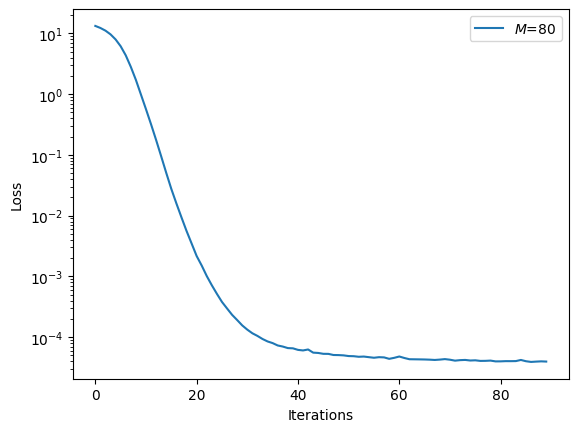

Performing time measurements:  11%|█         | 1/9 [00:55<07:22, 55.33s/it]

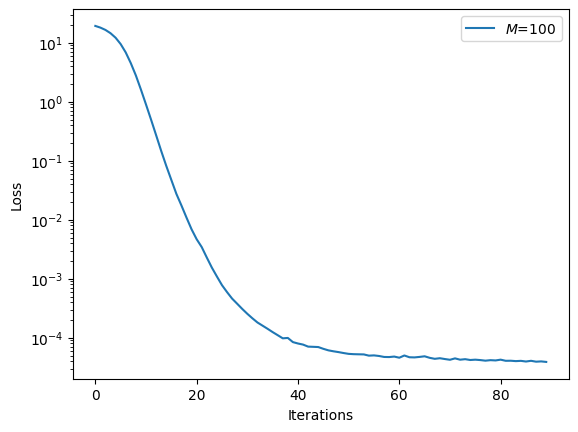

Performing time measurements:  22%|██▏       | 2/9 [01:55<06:47, 58.26s/it]

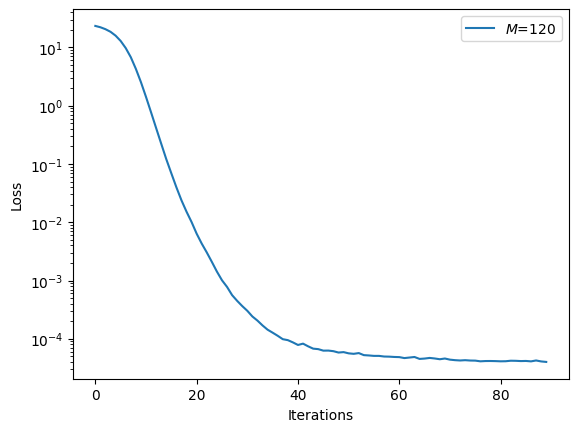

Performing time measurements:  33%|███▎      | 3/9 [03:05<06:22, 63.72s/it]

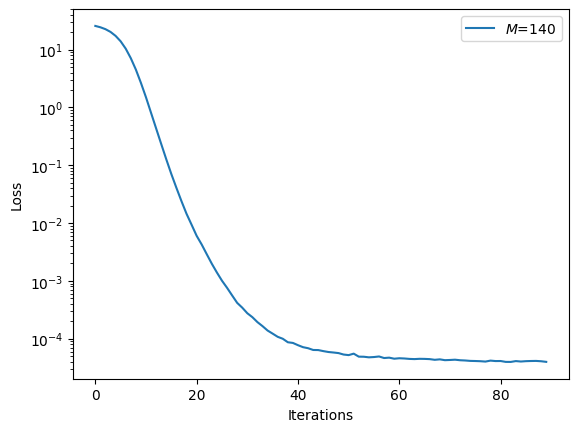

Performing time measurements:  44%|████▍     | 4/9 [04:22<05:44, 68.96s/it]

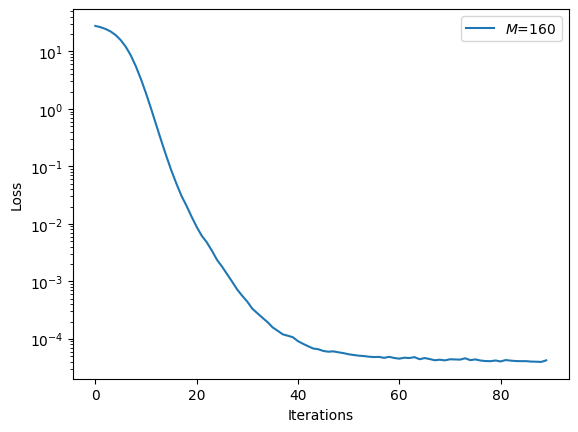

Performing time measurements:  56%|█████▌    | 5/9 [05:58<05:14, 78.71s/it]

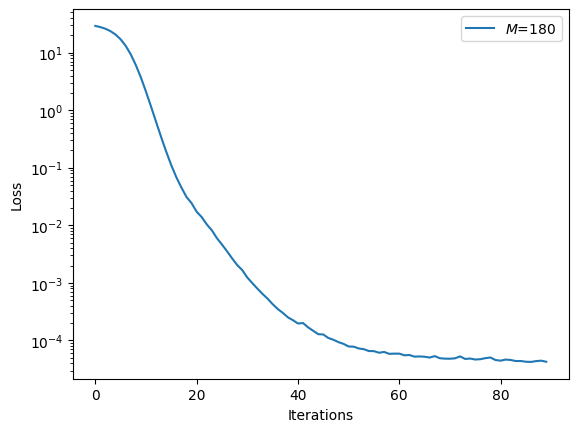

Performing time measurements:  67%|██████▋   | 6/9 [07:48<04:28, 89.37s/it]

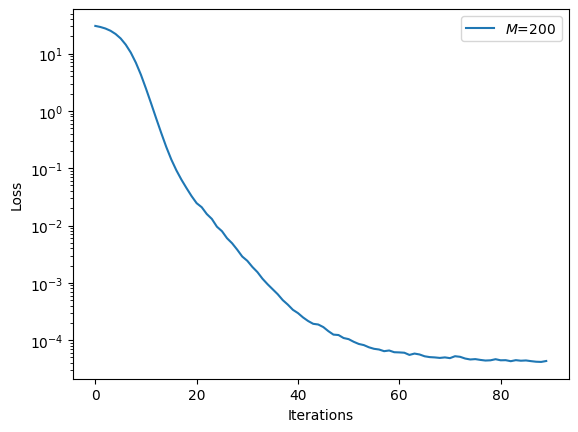

Performing time measurements:  78%|███████▊  | 7/9 [09:58<03:25, 102.59s/it]

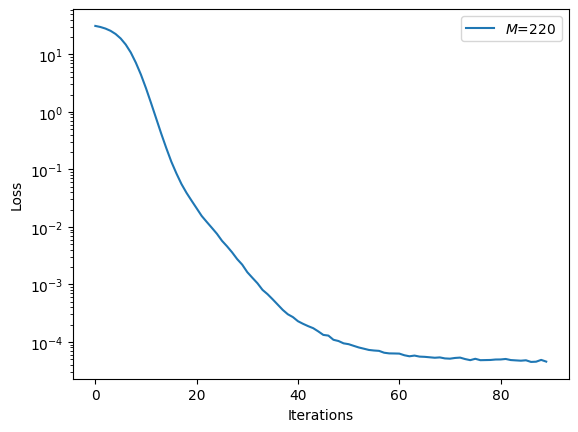

Performing time measurements:  89%|████████▉ | 8/9 [12:33<01:59, 119.05s/it]

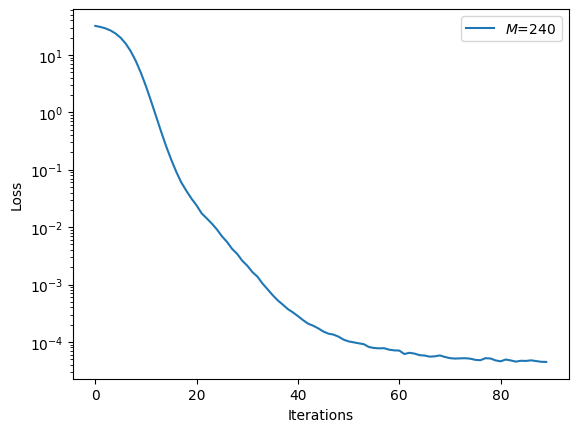

Performing time measurements: 100%|██████████| 9/9 [15:38<00:00, 104.26s/it]


In [2]:
Ms = range(80, 260, 20)
device = 'cuda'
N = 25
D = 1000
number = 5
time_gd = []
time_mosek = []
avg_fids_gd = []
avg_fids_mosek = []


for M in tqdm(Ms, desc="Performing time measurements"):
    # PNR detector POVM
    eta = 0.8 #random.uniform(0.1, 0.9)
    true_povm = pnr_povm(hilbert_dim=M, N=N, eta=eta)
    true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T

    max_avg = find_lambda_for_poisson(M, threshold=1e-5)
    n_bars = np.linspace(0, max_avg, D)
    probes = th.tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars ])) 

    targets = probes @ true_povm  
    lam_smoothing = 1e-5
    hyperparams = Hyperparameters(lr=0.01, lr_decay=0.999, beta1=0.9, beta2=0.9, num_epochs=90, batch_size=45)

    M, N, = probes.shape[1], targets.shape[1]
    logits = th.rand((M, N)) - 1
    logits = logits.to(device)
    logits.requires_grad = True

    probes = probes.to(device)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)
    
    logits, losses, _, _ = learn_phase_insensitive_povm(logits, hyperparams, dataset, lam_smoothing, False)
    plt.plot(losses, label=rf"$M$={M}")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.show();

    Pi = th.softmax(logits, dim=1).to('cpu')  # rows are probability vectors so apply softmax along them
    
    if check_diag_povm(Pi.T, tol=1e-5) is not True:
        print(f"WARNING: Gradient descent got invalid solution POVM for M={M}")

    Fs = [ diag_povm_fidelity(th.diag(Pi[:, i]), true_povm[:, i]) for i in range(true_povm.shape[1]) ]
    avg_fids_gd.append(sum(Fs)/len(Fs))

    Pi, prob, iters = phase_insensitive_loss_cvx(targets.cpu().numpy(), probes.cpu().numpy(), lam_smoothing, "MOSEK")
    Pi = th.tensor(Pi)

    if check_diag_povm(Pi.T, tol=1e-5) is not True:
        print(f"WARNING: CVXPY got invalid solution POVM for M={M}")

    Fs = [ diag_povm_fidelity(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]
    avg_fids_mosek.append(sum(Fs)/len(Fs))

    # compute times
    t = timeit(lambda: learn_phase_insensitive_povm(logits, hyperparams, dataset, lam_smoothing, False), number=number)
    time_gd.append(t / number) 

    t = timeit(lambda: phase_insensitive_loss_cvx(targets.cpu().numpy(), probes.cpu().numpy(), lam_smoothing, "MOSEK"), number=number) 
    time_mosek.append(t / number)

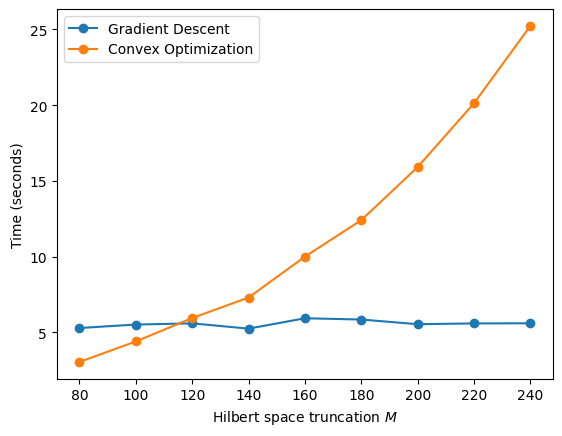

In [3]:
plt.plot(Ms, time_gd, label="Gradient Descent", marker="o")
plt.plot(Ms, time_mosek, label="Convex Optimization", marker="o")
plt.xlabel(r"Hilbert space truncation $M$ ")
plt.ylabel("Time (seconds)")
# plt.yscale("log")
plt.legend();

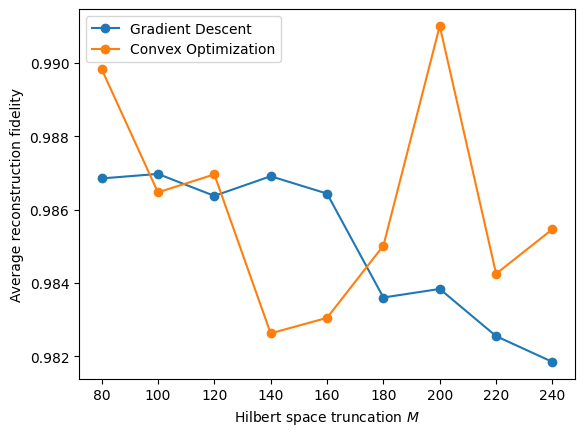

In [4]:
plt.plot(Ms, avg_fids_gd, label="Gradient Descent", marker="o")
plt.plot(Ms, avg_fids_mosek, label="Convex Optimization", marker="o")
plt.xlabel(r"Hilbert space truncation $M$ ")
plt.ylabel("Average reconstruction fidelity")
# plt.yscale("log")
plt.legend();

### Memory complexity

In [10]:
Ms = range(50, 200, 50)
device = 'cuda'
mem_usage_gd = []
mem_usage_mosek = []
mem_usage_scs = []

for M in Ms:
    # PNR detector POVM
    eta = random.uniform(0.1, 0.9)
    true_povm = pnr_povm(hilbert_dim=M, N=N, eta=0.9)
    true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T

    max_avg = M/1.75
    n_bars = np.linspace(0, max_avg, D)
    probes = th.tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars ])) 

    targets = probes @ true_povm  
    lam_smoothing = 1e-5
    hyperparams = Hyperparameters(lr=0.1, lr_decay=0.999, beta1=0.9, beta2=0.9, num_epochs=50, batch_size=32)

    M, N, = probes.shape[1], targets.shape[1]
    logits = th.rand((M, N)) - 1
    logits = logits.to(device)
    logits.requires_grad = True

    probes = probes.to(device)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)
    
    mem = memory_usage( (learn_phase_insensitive_povm, (logits, hyperparams, dataset, lam_smoothing)) )
    mem_usage_gd.append(max(mem) / 1000)  # divide by 1k to go from Mb to Gb

    mem = memory_usage( (phase_insensitive_loss_cvx, (targets.cpu().numpy(), probes.cpu().numpy(), lam_smoothing, "MOSEK")) ) 
    mem_usage_mosek.append(max(mem) / 1000)


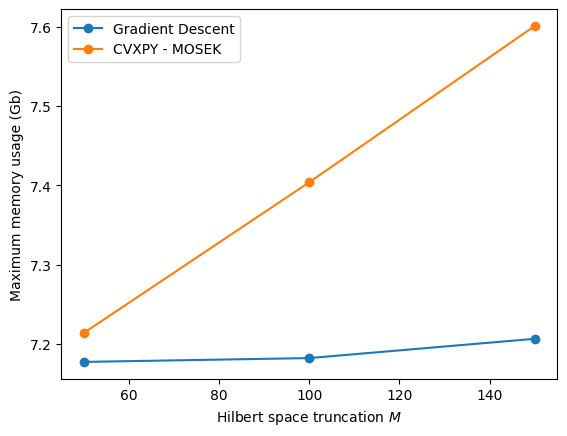

In [11]:
plt.plot(Ms, mem_usage_gd, label="Gradient Descent", marker="o")
plt.plot(Ms, mem_usage_mosek, label="CVXPY - MOSEK", marker="o")
plt.xlabel(r"Hilbert space truncation $M$ ")
plt.ylabel("Maximum memory usage (Gb)")
# plt.yscale("log")
plt.legend();